In [1]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import functions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.image as mpimg

In [2]:
# IMPORT VEHICLE POPULATION DATA WHICH IS BROKEN DOWN BY TYPE OF CAR
df_cars = pd.read_csv('data/Light-Duty-Vehicle-Population-2010-2023.csv', low_memory=False)

print(f"The dataframe has {df_cars.shape[0]} and {df_cars.shape[1]} columns")

The dataframe has 33542 and 7 columns


## Data Preparation

### The California's Energy Department Website Data Describes the Population and Type of Light-Duty Vehicles
https://www.energy.ca.gov/data-reports/energy-almanac/zero-emission-vehicle-and-infrastructure-statistics-collection/light

In [3]:
# Review the features of the dataset
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33542 entries, 0 to 33541
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Data Year                  33542 non-null  int64 
 1   County                     33542 non-null  object
 2   Dashboard Fuel Type Group  33542 non-null  object
 3   Fuel Type                  33542 non-null  object
 4   Make                       28924 non-null  object
 5   Model                      28924 non-null  object
 6   Number of Vehicles         33542 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.8+ MB


In [4]:
df_cars.columns

Index(['Data Year', 'County', 'Dashboard Fuel Type Group', 'Fuel Type', 'Make',
       'Model', 'Number of Vehicles'],
      dtype='object')

In [5]:
# Filter out data for Santa Barbara County only
df_cars = df_cars.query("County == 'Santa Barbara'")
print(f"The dataframe has {df_cars.shape[0]} and {df_cars.shape[1]} columns")

The dataframe has 782 and 7 columns


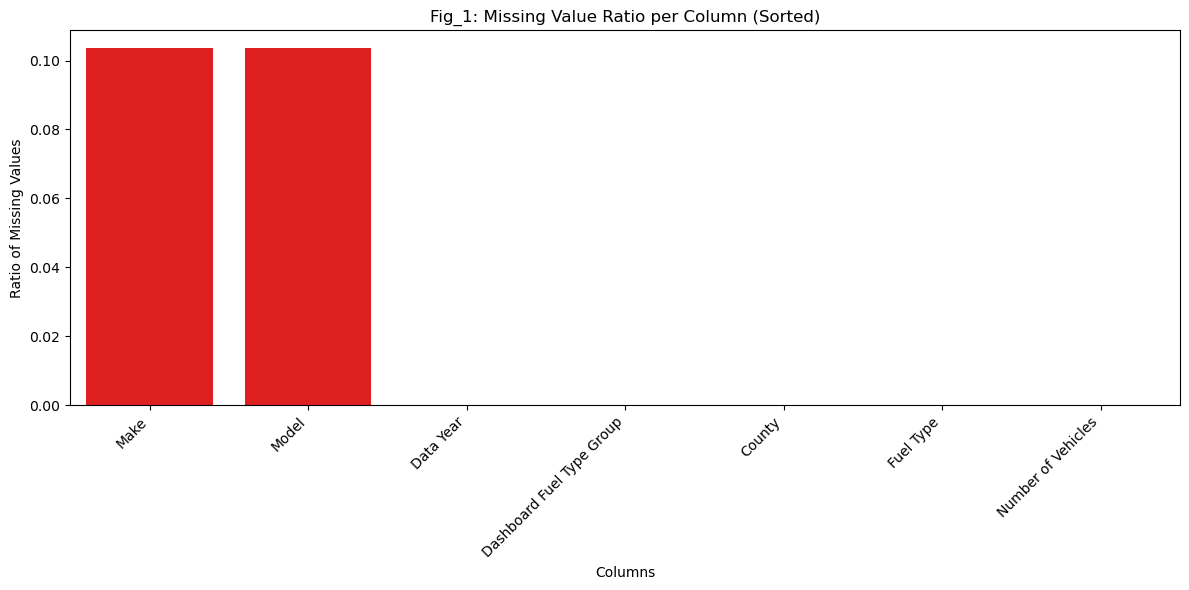

In [6]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing. 
df_cars_w_missing_values = df_cars.isnull().mean().sort_values(ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = sns.barplot(x=df_cars_w_missing_values.index, y=df_cars_w_missing_values.values, color='red')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Ratio of Missing Values')
plt.title('Fig_1: Missing Value Ratio per Column (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

3# Save the plot
plt.savefig('images/cars/fig1.jpg')

# Show the plot
plt.show()

In [7]:
# Since 'Make', 'Model' and 'Dashboard Fuel Type Group' are not important for our efforts.
# Additionally, 'County' has already been filtered to Santa Barbara 
# Thus we can remove these features

df_cars = df_cars.drop(['Make', 'Model', 'County', 'Dashboard Fuel Type Group'], axis=1)
print(f"The dataframe has {df_cars.shape[0]} and {df_cars.shape[1]} columns")

The dataframe has 782 and 3 columns


In [8]:
# Create two new columns to separate BEV and non-BEV vehicle counts
df_cars['Number of BEV Vehicles'] = 0
df_cars['Number of NON BEV Vehicles'] = 0

# Fill in values based on the fuel type
mask_bev = df_cars['Fuel Type'] == 'Battery Electric (BEV)'
df_cars.loc[mask_bev, 'Number of BEV Vehicles'] = df_cars.loc[mask_bev, 'Number of Vehicles']
df_cars.loc[~mask_bev, 'Number of NON BEV Vehicles'] = df_cars.loc[~mask_bev, 'Number of Vehicles']

# Now we can group by year to get the totals
yearly_summary = df_cars.groupby('Data Year').agg({
    'Number of BEV Vehicles': 'sum',
    'Number of NON BEV Vehicles': 'sum',
    'Number of Vehicles': 'sum'  # Total vehicles
})

# Calculate percentage of BEVs
yearly_summary['BEV Percentage'] = (yearly_summary['Number of BEV Vehicles'] / 
                                    yearly_summary['Number of Vehicles']) * 100

# Display the result
print(yearly_summary)

           Number of BEV Vehicles  Number of NON BEV Vehicles  \
Data Year                                                       
2010                           11                      251651   
2011                           47                      250998   
2012                           76                      252757   
2013                          221                      261121   
2014                          388                      268575   
2015                          562                      273084   
2016                          795                      284081   
2017                         1223                      318708   
2018                         1881                      321259   
2019                         2485                      324451   
2020                         3243                      322675   
2021                         4591                      337430   
2022                         6262                      328009   
2023                     

In [9]:
# First, create a copy of the yearly_summary DataFrame
yearly_summary_timeline = yearly_summary.copy()

# Reset the index to make 'Data Year'
yearly_summary_timeline = yearly_summary_timeline.reset_index()

# Now convert to datetime
yearly_summary_timeline['Data Year'] = pd.to_datetime(yearly_summary_timeline['Data Year'], format='%Y')

# Set as index
yearly_summary_timeline = yearly_summary_timeline.set_index('Data Year')

# Display the result
yearly_summary_timeline.head()

,Number of BEV Vehicles,Number of NON BEV Vehicles,Number of Vehicles,BEV Percentage
Data Year,,,,
2010-01-01,11,251651,251662,0.004371
2011-01-01,47,250998,251045,0.018722
2012-01-01,76,252757,252833,0.030059
2013-01-01,221,261121,261342,0.084564
2014-01-01,388,268575,268963,0.144258


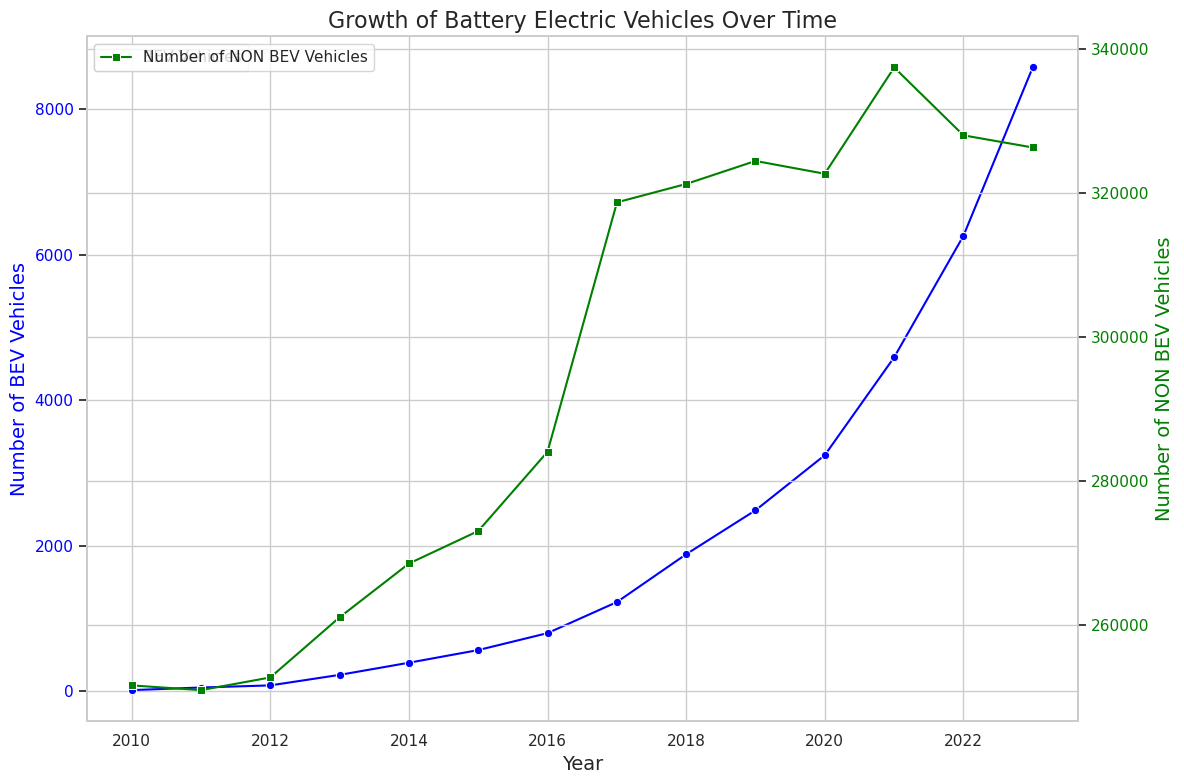

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set the style for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Reset index to make the date a column for Seaborn
plot_data = yearly_summary_timeline.reset_index()

# Create a line plot for the number of vehicles
ax1 = sns.lineplot(data=plot_data, 
                  x='Data Year',  # Specify the x-axis column
                  y='Number of BEV Vehicles', 
                  color='blue', 
                  marker='o',
                  label='BEV Vehicles')

ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of BEV Vehicles', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the percentage
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, 
             x='Data Year',  # Specify the x-axis column
             y='Number of NON BEV Vehicles', 
             ax=ax2, 
             color='green', 
             marker='s',
             label='Number of NON BEV Vehicles')

ax2.set_ylabel('Number of NON BEV Vehicles', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Format the x-axis to show years nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add a title
plt.title('Growth of Battery Electric Vehicles Over Time', fontsize=16)

# Add legends
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
plot_data.columns

Index(['Data Year', 'Number of BEV Vehicles', 'Number of NON BEV Vehicles',
       'Number of Vehicles', 'BEV Percentage'],
      dtype='object')

In [14]:
series = plot_data['Number of BEV Vehicles']

In [15]:
percent_diff = [((series[i] - series[i-1]) / series[i-1]) * 100 for i in range(1, len(series))]

In [16]:
print(percent_diff)

[327.2727272727273, 61.702127659574465, 190.78947368421052, 75.56561085972851, 44.84536082474227, 41.45907473309609, 53.83647798742138, 53.80212591986917, 32.110579479000535, 30.503018108651915, 41.56645081714462, 36.397299063384885, 36.98498882146279]


In [2]:
# The resulting percentage difference that will be used for scenario projections in the data-analysis-days.ipynb file is thus:
ev_adoption_growth_factor = 1.3698